In [27]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [28]:
# Graph used in all examples below
def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            #and connect the node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [29]:
# Simple quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

In [30]:
f(3.0)

20.0

In [31]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [32]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

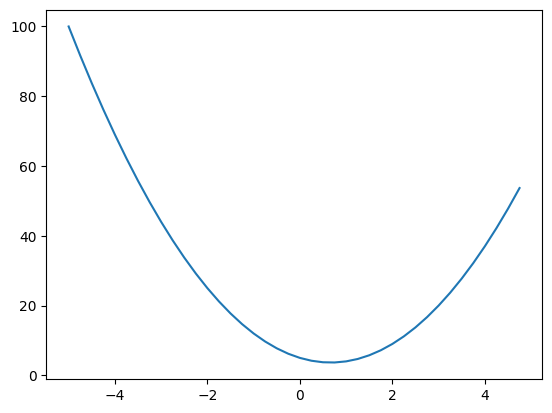

In [33]:
# Visual representation of the quadratic function with sample inputs
plt.plot(xs,ys)
plt.show()

In [34]:
# Derivative
h = 0.00001 #this goes to 0 but if you add too many 0s you'll get a wrong answer because computers use floating point arithmetic

x = 3.0
print(f(x))
print(f(x + h))
print((f(x+h) - f(x))/h) # slope goes up

20.0
20.0001400003
14.00003000000538


In [15]:
x=-3.0
print((f(x+h) - f(x))/h) # slope goes down

-21.999970000052823


In [16]:
x=2/3
print((f(x+h) - f(x))/h) # 0

3.0000002482211127e-05


In [17]:
#more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [18]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

#derivative of d w.r.t a
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [19]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
#derivative of d w.r.t b
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [20]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
#derivative of d w.r.t c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [45]:
#from Karpathy's micrograd lib
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        '''Provides a nicer looking expression. 
           Without it, we'd print out only the memory place allocation
        '''
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*')
        return out    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
#d = a * b + c
#(a.__mul__(b)).__add__(c)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [46]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [47]:
d._op

'+'

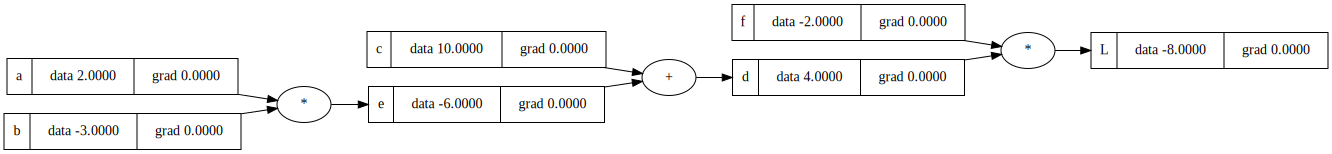

In [26]:
draw_dot(L)

## Manual Backprogation: calculate gradients

In [22]:
#from Karpathy's micrograd lib
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #default gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        '''Provides a nicer looking expression. 
           Without it, we'd print out only the memory place allocation
        '''
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*')
        return out    

In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
#d = a * b + c
#(a.__mul__(b)).__add__(c)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

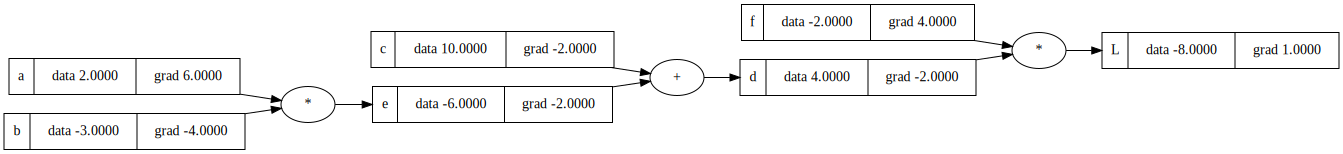

In [42]:
draw_dot(L)


In [51]:
# manual backpropagation - set the derivative of L to 1
L.grad = 1.0

We know the gradient of L is 1.
L = d * f
dL/dd = ? - f
This can also be proved by the definition of derivative
(f(x+h) - f(x))/h 
((d+h)*f - d*f)/h
(df + hf - d*f)/h
hf/h
f 

Symmetrically, dL/df = d


In [52]:
f.grad = 4.0 #value of d
d.grad = -2.0 #value of f

dL / dc?

dd / dc = 1.0
d = c + e

by symmetry dd / de = 1.0

Using chain rule

want: dL/dc
know: 
dL/dd
dd / dc

dL/dc = dL/dd * dd/dc = -2.0 * 1 = -2.0

dL/de = dL/dd * dd/de = -2.0 * 1 = -2.0


In [53]:
c.grad = -2.0
e.grad = -2.0

dL / da?

e = a * b

de/da = b = -3.0
de/db = a = 2.0

dL / da = dL/de * de/da = -2.0 * -3.0 = 6.0
dL / db = dL/de * de/db = -2.0 * 2.0 = -4.0

In [54]:
a.grad = 6.0
b.grad = -4.0

In [39]:
# Can use it to check any of the calculated gradients above
def lol():
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    #d = a * b + c
    #(a.__mul__(b)).__add__(c)
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    #a = Value(2.0 + h, label='a')
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    #c.data += h
    e = a*b; e.label='e'
    e.data += h
    #d = a * b + c
    #(a.__mul__(b)).__add__(c)
    d = e + c; d.label = 'd'
    #d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    #L2 = L.data + h
    L2 = L.data
    
    print((L2-L1)/h)

In [40]:
lol()

-2.000000000000668


In [57]:
print(a.data)
a.data += 0.01 + a.grad
print(a.data)

2.0
2.01


In [58]:
print(b.data)
b.data += 0.01 + b.grad
print(b.data)

-3.0
-2.99


In [59]:
print(c.data)
c.data += 0.01 + c.grad
print(c.data)

10.0
10.01


In [60]:
print(f.data)
f.data += 0.01 + f.grad
print(f.data)

-2.0
-1.99


In [61]:
print(d.data)

4.0


In [69]:
# NN in action
# We want to make L go up (become less negative)
# Nudge all the inputs in the direction of the gradient
a.data += 0.01 + a.grad

b.data += 0.01 + b.grad
c.data += 0.01 + c.grad
f.data += 0.01 + f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.920792


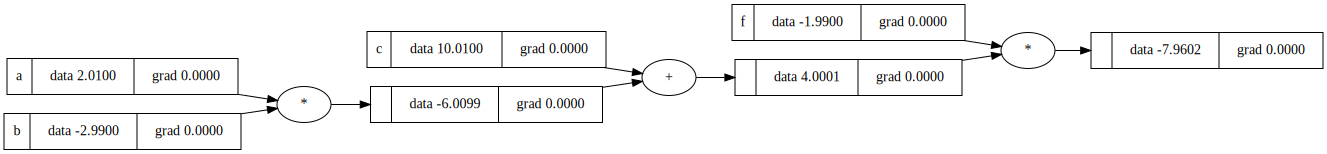

In [68]:
draw_dot(L)

## Manual Backpropagation: a Neuron

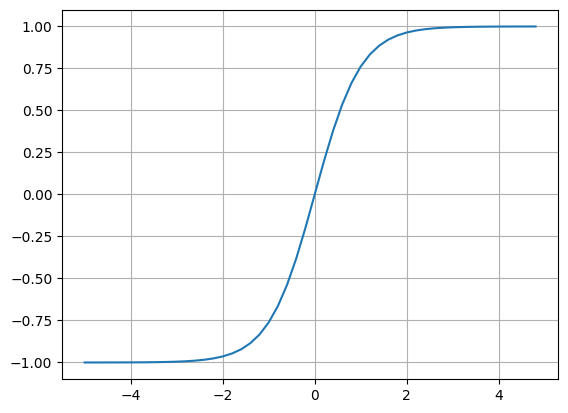

In [2]:
# Example of a squashing function - squashes outputs for the x axis
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.show()

In [37]:
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #default gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        '''Provides a nicer looking expression. 
           Without it, we'd print out only the memory place allocation
        '''
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

In [38]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigts w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
# with a bias of 6.7 the tanh is not squashing too much 
# since output was low
# increase to 8
#b = Value(8.0, label='b')
b = Value(6.8813735870195432, label='b')

# all the below is to get the final form
# x1*w1 + x2*w2 + b - everything without the activation function
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# if we recompute x1*w1 or x2*w2 
# This creates new Value objects, so the labels on x1w1 and x2w2 won’t appear upstream.
#x1w1x2w2 = x1*w1 + x2*w2; 
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
# we can't use the default tanh fucntion 
# since our engine does not have exponents and division
# which are needed - implement tanh in the class
o = n.tanh(); o.label = 'o'

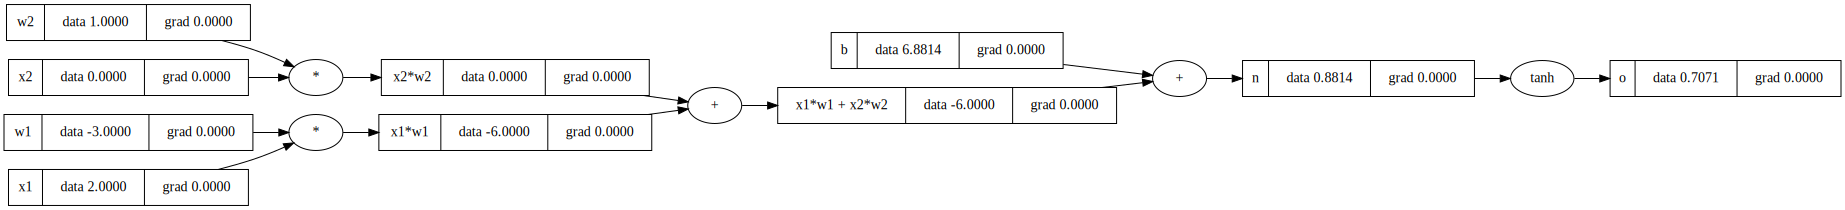

In [39]:
draw_dot(o)

In [163]:
o.grad = 1.0

In [164]:
n.grad = 1 - o.data**2
n.grad

0.4999999999999999

In [165]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

x1*w1 + x2*w2
again plus node so again distributing the same gradient

In [166]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [167]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [168]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

## Implement an automatic backpropagation

In [27]:
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #default gradient
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        '''Provides a nicer looking expression. 
           Without it, we'd print out only the memory place allocation
        '''
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # when addition only propagating the gradient
            #self.grad = 1.0 * out.grad
            #other.grad = 1.0 * out.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            #self.grad = other.data * out.grad
            #other.grad = self.data * out.grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            #self.grad = (1 - t**2) * out.grad
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        # don't do out._backward = _backward()
        # this will return and the function returns nothing
        # calling without () only stores it
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # add itself only after all children have been added
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

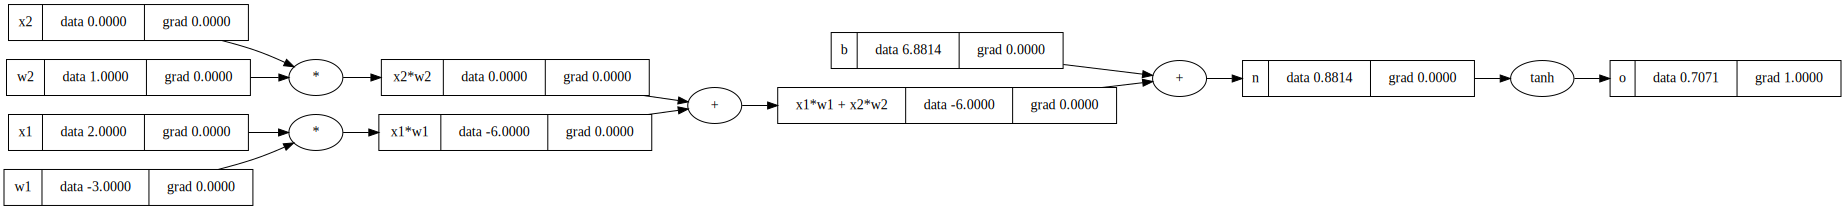

In [12]:
draw_dot(o)

In [172]:
o.grad = 1.0
# initialize with 1 - in the class it's 0.0 so it will multiply by 0

In [13]:
o._backward()

In [14]:
n._backward()

In [15]:
b._backward()

In [16]:
x1w1x2w2._backward()

In [17]:
x2w2._backward()

In [18]:
x1w1._backward()

In [40]:
# So as not to call backward manually on each element
# Implement topological sort - like a DAG, it sets the elements
# So that they only go from left to right
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        # add itself only after all children have been added
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
for node in reversed(topo):
    node._backward()

In [20]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigts w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
# with a bias of 6.7 the tanh is not squashing too much 
# since output was low
# increase to 8
#b = Value(8.0, label='b')
b = Value(6.8813735870195432, label='b')

# all the below is to get the final form
# x1*w1 + x2*w2 + b - everything without the activation function
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# if we recompute x1*w1 or x2*w2 
# This creates new Value objects, so the labels on x1w1 and x2w2 won’t appear upstream.
#x1w1x2w2 = x1*w1 + x2*w2; 
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
# we can't use the default tanh fucntion 
# since our engine does not have exponents and division
# which are needed - implement tanh in the class
o = n.tanh(); o.label = 'o'

In [21]:
o.grad = 1.0

In [23]:
o.backward()

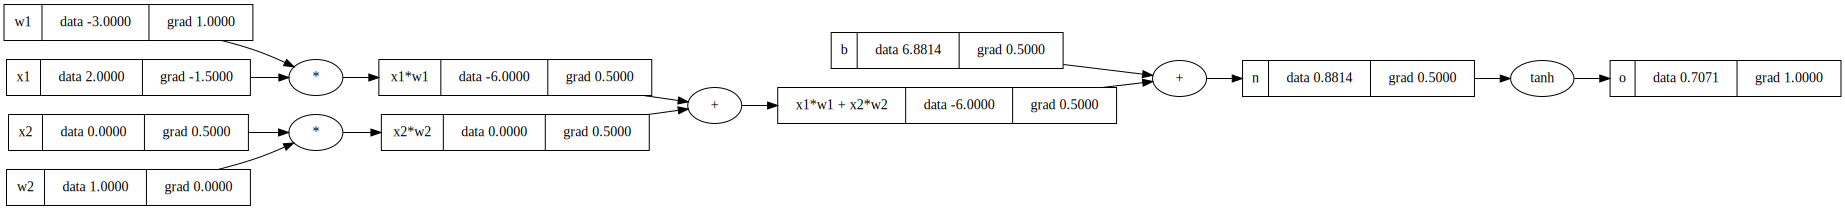

In [24]:
draw_dot(o)

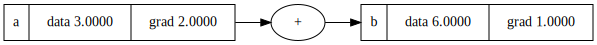

In [28]:
## Fixing a logical bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

The gradient of a is not correct. It should be 2.
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        # when addition only propagating the gradient
        self.grad = 1.0 * out.grad
        other.grad = 1.0 * out.grad
    out._backward = _backward
    return out
    
Since self.data and other.data are the same object, it overwrites the gradient with 1 * 1 = 1

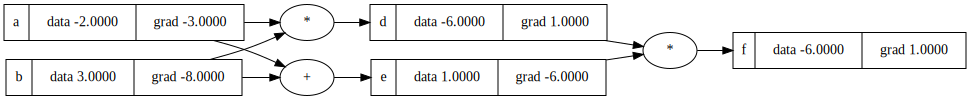

In [29]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b  ; d.label = 'd'
e = a + b  ; e.label = 'e'
f = d * e  ; f.label = 'f'

f.backward()

draw_dot(f)

## Break up tanh and implement it in the class

In [28]:
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #default gradient
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        '''Provides a nicer looking expression. 
           Without it, we'd print out only the memory place allocation
        '''
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data **(other-1) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [33]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigts w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# all the below is to get the final form
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()

In [13]:
# Currently can't do a + 1 
#since Python will try to access .data and 1 doesn't have it
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [21]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

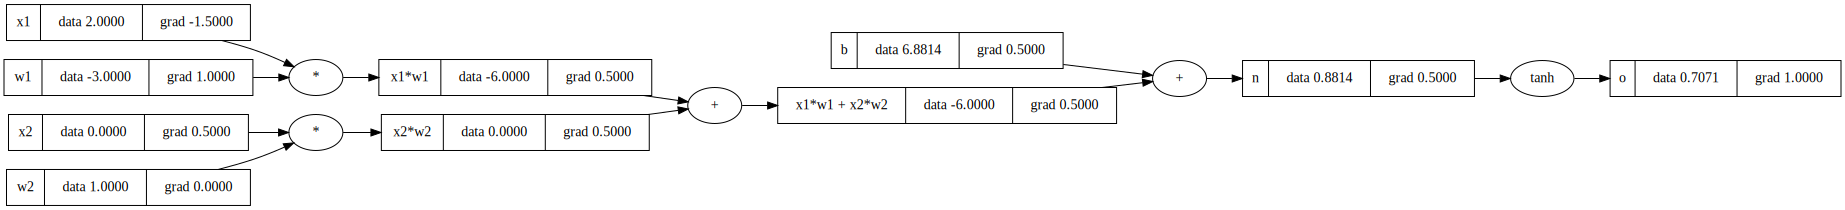

In [34]:
draw_dot(o)

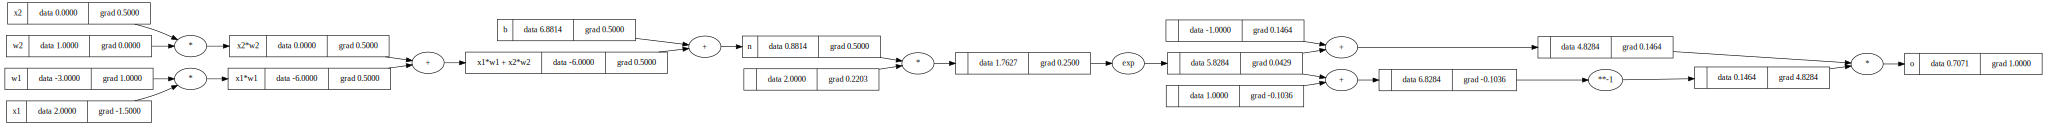

In [35]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigts w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# all the below is to get the final form
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
#------------
#o = n.tanh(); 
# define o with the implemented operations
e = (2*n).exp()
o = (e - 1)/(e + 1)
#------------
o.label = 'o'

o.backward()
draw_dot(o)

## Implement same with pytorch

In [11]:
import torch

# all leaf nodes so explicitly say they need a gradient
x1 = torch.Tensor([2.0]).double()     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()     ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()     ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [6]:
#default Tensor is an array, not a scalar
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [10]:
# by default it will create it as a float32 
# which only has 1 precision so casting to double to add precision
torch.Tensor([2.0]).dtype
torch.Tensor([2.0]).double().dtype

torch.float64

In [12]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [14]:
o.item()

0.7071066904050358

In [15]:
o.data.item()

0.7071066904050358

In [16]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [17]:
x2.grad.item()

0.5000001283844369

## Building a NN with real inputs

In [23]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        print(list(zip(self.w, x)))
        
        return 0.0
    
x = [2.0, 3.0]
n = Neuron(2)
#when using this notation, python uses __call__
n(x)

[(Value(data=0.037278504782650046), 2.0), (Value(data=-0.7354211464150116), 3.0)]


0.0

In [40]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

In [41]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.13840489010114096)

In [25]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [18]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)


[Value(data=0.9974070462035942),
 Value(data=-0.9086016888592523),
 Value(data=0.4960377439942363)]

In [26]:
x = [2.0, 3.0, -1.0]
#3 inputs into 2 layers of 4 and 1 output
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.1821815195639)

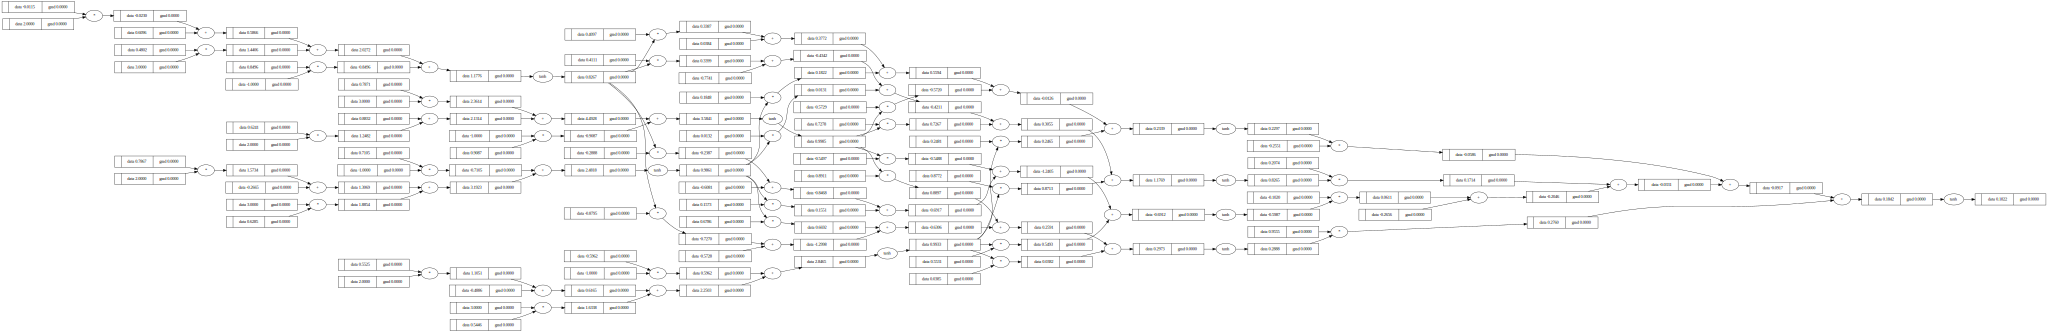

In [31]:
draw_dot(n(x))

In [32]:
# A very simple binary classifier
# outputs either 1 or -1 for each of the 4 inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # targets

In [34]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.1821815195639),
 Value(data=0.36701111022685884),
 Value(data=-0.07252087989626656),
 Value(data=0.23735178924505895)]

In [35]:
#implement mean squared error loss (can also do absolute, but need to discard sign)
# ygt: y ground truth
# yout: NN predicted y
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.6688270669428116),
 Value(data=1.8687193754836695),
 Value(data=0.8602175182283957),
 Value(data=0.5816322933677129)]

In [36]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.97939625402259)

In [37]:
loss.backward()

In [38]:
n.layers[0].neurons[0].w[0]

Value(data=-0.0115071511048348)

In [39]:
n.layers[0].neurons[0].w[0].grad

-1.7552776629052904

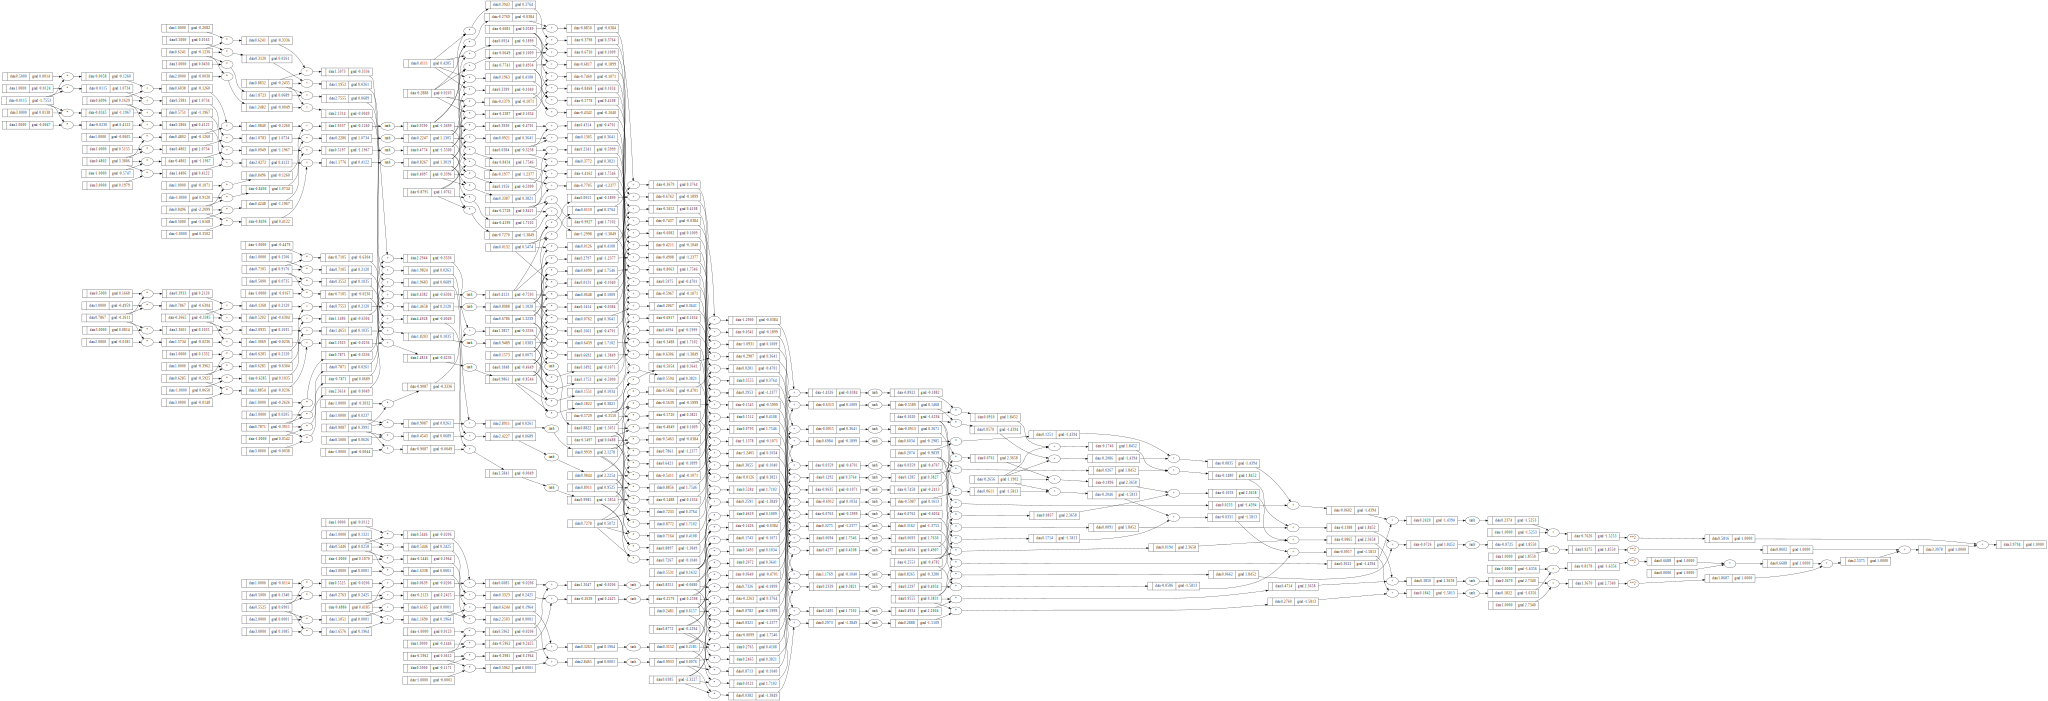

In [40]:
draw_dot(loss)

Now we want to be able to get all the parameters of the NN
So we can nudge them a little bit using their gradient

In [46]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

    def parameters(self):
        # list + list = list
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
#         params = []
#         for neuron in self.neurons:
#             ps = neuron.parameters()
#             params.extend(ps)
#         return params
        #shorter equivalent
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    "multilayer perceptron"
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [47]:
#Since just added params we'll need to reinitialize the network
#Which will change the numbers
x = [2.0, 3.0, -1.0]
#3 inputs into 2 layers of 4 and 1 output
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6173627736444781)

In [48]:
n.parameters()

[Value(data=-0.27550710924545263),
 Value(data=-0.8722104085396012),
 Value(data=-0.7282090278149278),
 Value(data=-0.6502071672109409),
 Value(data=0.9281259792180319),
 Value(data=0.7080728858801268),
 Value(data=0.3234241860166911),
 Value(data=0.5653741807883932),
 Value(data=-0.906112333650865),
 Value(data=0.29873797910552047),
 Value(data=-0.49692557260245684),
 Value(data=-0.25618304474865194),
 Value(data=-0.05782877260316077),
 Value(data=-0.7029973336789475),
 Value(data=0.8035360162745824),
 Value(data=-0.1844078790002548),
 Value(data=-0.04921476983996853),
 Value(data=0.39933395686918294),
 Value(data=0.38526029886514435),
 Value(data=-0.7250543477002738),
 Value(data=0.9826752591595247),
 Value(data=0.581321552180762),
 Value(data=-0.8102370836638377),
 Value(data=0.6140542483699829),
 Value(data=-0.8357075842544863),
 Value(data=-0.465616979856057),
 Value(data=-0.7103729273978698),
 Value(data=-0.5196371657847609),
 Value(data=-0.7234325841753924),
 Value(data=-0.76772

In [49]:
len(n.parameters())

41

In [50]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # targets

In [52]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6173627736444781),
 Value(data=-0.344905615194008),
 Value(data=-0.5201474856806723),
 Value(data=-0.2914036791912786)]

In [53]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.9429928927026525)

In [54]:
loss.backward()

In [55]:
# gradient of the weight w.r.t the loss function
n.layers[0].neurons[0].w[0].grad

0.4307975178755674

In [56]:
#value of the weight
n.layers[0].neurons[0].w[0].data

-0.27550710924545263

Gradient can be thought of as a vector pointing in the direction of an increased loss - but we want to minimize it so nudging all params with a tiny negative amount

In [57]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [58]:
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

0.4307975178755674
-0.2798150844242083


We know expect the loss to have gone down

In [59]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.5020565162954513)

Loss was 4.9429928927026525 and is now 3.5020565162954513
Now need to reiterate through the process

In [60]:
loss.backward()

In [61]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [62]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.4124268708364593)

In [89]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0004754376215725246)

In [90]:
loss.backward()

In [91]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [92]:
# After approx 10 passes of the above
ypred

[Value(data=0.9873108564940801),
 Value(data=-0.9973220488917617),
 Value(data=-0.9830930124719882),
 Value(data=0.995373380364863)]

In [93]:
n.parameters()

[Value(data=-0.5889146769041956),
 Value(data=-0.47999038716743003),
 Value(data=-1.0768613899052202),
 Value(data=-0.6234156964460743),
 Value(data=0.9085647336055704),
 Value(data=0.6983587431298898),
 Value(data=0.2697066687460948),
 Value(data=0.5421823153189563),
 Value(data=-0.028176531642423966),
 Value(data=1.2027594101314483),
 Value(data=-2.0412706112000882),
 Value(data=-0.045960380909639734),
 Value(data=-0.12216184530589061),
 Value(data=-0.747651246686581),
 Value(data=0.7162056007734412),
 Value(data=-0.25688988409914937),
 Value(data=0.42377511981323057),
 Value(data=-0.137492720128421),
 Value(data=0.8482916970054952),
 Value(data=-0.9434100417686034),
 Value(data=0.4363867539251211),
 Value(data=0.40135423717550656),
 Value(data=-0.5991036862714677),
 Value(data=0.5714645124044414),
 Value(data=-1.1222794051659886),
 Value(data=-0.24925783320152484),
 Value(data=-1.0929896918296236),
 Value(data=-0.11292313166300848),
 Value(data=-1.2540052311643006),
 Value(data=-0.1

## Implement a proper training loop

In [98]:
#Initialize NN from scratch
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5795494234030593)

In [99]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [112]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    # flush gradients
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.00454798390156924
1 0.004505949877188825
2 0.00446467412073971
3 0.004424136423008938
4 0.0043843172840451385
5 0.004345197882390312
6 0.004306760045896174
7 0.004268986224031526
8 0.004231859461592102
9 0.004195363373731277
10 0.00415948212223473
11 0.004124200392967351
12 0.004089503374425801
13 0.004055376737333902
14 0.004021806615222149
15 0.003988779585936582
16 0.003956282654025889
17 0.003924303233957987
18 0.003892829134121303
19 0.003861848541568366


In [113]:
ypred

[Value(data=0.9714882651835535),
 Value(data=-0.9728651953542072),
 Value(data=-0.9642963760020755),
 Value(data=0.967783806407732)]